In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usa-airport-dataset/Airports2.csv


# Flight Network Analysis (Q1)

In [8]:
#Import the dataset
airports = pd.read_csv('/kaggle/input/usa-airport-dataset/Airports2.csv')

In [9]:
airports.columns

Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')

# Task 1 : Define the function "analyze_graph_features"

Implement a function analyze_graph_features(flight_network) that takes the flight network as input and computes the following:

* Count the number of airports (nodes) and flights (edges) in the graph.
* Compute the density of the graph using the formula: 
* Calculate both in-degree and out-degree for each airport and visualize them using histograms.
* Identify airports with degrees higher than the 90th percentile and list them as "hubs."
* Determine if the graph is sparse or dense based on its density.




In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [26]:
def analyze_graph_features(flight_network):
    nodes = set(flight_network.nodes())
    #Count nodes and edges
    n_nodes = len(flight_network.nodes())
    n_edges = len(list(flight_network.edges()))
    
    #Density
    density = n_edges / (n_nodes * (n_nodes - 1)) if n_nodes > 1 else 0 #density for an oriented graph

    #In-degree and out-degree
    in_degrees = {node: 0 for node in nodes}
    out_degrees = {node: 0 for node in nodes}

    for origin, destination in flight_network.edges():
        out_degrees[origin] += 1
        in_degrees[destination] += 1

    #Plot degree distributions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees.values(), bins=20, color='skyblue', edgecolor='black')
    plt.title('In-degree distribution')
    plt.xlabel('In-degree')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(out_degrees.values(), bins=20, color='salmon', edgecolor='black')
    plt.title('Out-degree distribution')
    plt.xlabel('Out-degree')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    #Identify airports with degrees higher than the 90th percentile and list them as "hubs."
    total_degrees = {node: in_degrees[node] + out_degrees[node] for node in nodes}
    degree_threshold = np.percentile(list(total_degrees.values()), 90)
    hubs = [{"Airport": node,"Total degree": total_degrees[node],"In-degree": in_degrees[node],"Out-degree": out_degrees[node],}
        for node in nodes if total_degrees[node] > degree_threshold]
    hubs_dataframe = pd.DataFrame(hubs).sort_values(by="Total degree", ascending=False)

    #Determine if graph is sparse or dense
    graph_type = "dense" if density > 0.5 else "sparse"

    results = {
        "num_nodes": n_nodes,
        "num_edges": n_edges,
        "density": density,
        "hubs": hubs_dataframe,
        "graph_type": graph_type,
        "in_degrees": in_degrees,
        "out_degrees": out_degrees,
    }

    return results

# Task 2 : Define the function "summarize_graph_features"

Write a function summarize_graph_features(flight_network) that generates a detailed report of the graph's features. A summary report needs to include:

* The number of nodes and edges.
* The graph density
* Degree distribution plots for in-degree and out-degree.
* A table of identified hubs.

In [14]:
def summarize_graph_features(features):
    print("Summary report")
    print(f"Number of nodes: {features['num_nodes']}")
    print(f"Number of edges: {features['num_edges']}")
    print(f"Graph density: {features['density']:.4f}")
    print(f"Graph type: {features['graph_type']}")
    print("\nHubs (Airports with degree > 90th percentile):")
    print(features['hubs'])


# Task 3 : Deeper Analysis

Now let's dive deeper into the analysis of the dataset. Do the following:

* Compute total passenger flow between origin and destination cities.
* Identify and visualize the busiest routes by passenger traffic.
* Calculate the average passengers per flight for each route and highlight under/over-utilized connections.
* Create an interactive map visualizing the geographic spread of the flight network.


In [15]:
def analyze_routes(data):
    #Compute total passenger flow between origin and destination cities
    total_flow = data.groupby(['Origin_airport', 'Destination_airport', 'Origin_city', 'Destination_city'])['Passengers'].sum().reset_index()
    total_flow = total_flow.sort_values(by='Passengers', ascending=False)

    #Calculate average passengers per flight
    flight_counts = data.groupby(['Origin_airport', 'Destination_airport'])['Flights'].sum().reset_index()
    total_flow = total_flow.merge(flight_counts, on=['Origin_airport', 'Destination_airport'])
    total_flow['Avg_Passengers_Per_Flight'] = total_flow['Passengers'] / total_flow['Flights']

    return pd.DataFrame(total_flow)


In [16]:
#Plot the busiest routes by passenger flow
def plot_busiest_routes(total_flow):
    #Select the top 10 busiest routes by passenger flow
    top_routes = total_flow.head(10).copy()

    #Combine Origin and Destination into a single label
    top_routes['Route'] = (
        top_routes['Origin_airport'] + " (" + top_routes['Origin_city'] + ") → " +
        top_routes['Destination_airport'] + " (" + top_routes['Destination_city'] + ")"
    )

    # Plot the data
    plt.figure(figsize=(12, 8))
    plt.barh(top_routes['Route'], top_routes['Passengers'], color='orange')
    plt.xlabel("Total passengers")
    plt.ylabel("Routes")
    plt.title("Top 10 busiest routes by passenger flow")
    plt.gca().invert_yaxis()
    plt.show()


In [17]:
#Plot top routes by passenger efficiency
def plot_top_efficiency_routes(total_flow):
    #Select the top 10 routes by passenger efficiency
    total_flow = total_flow.sort_values(by='Avg_Passengers_Per_Flight', ascending=False)
    top_efficiency_routes = total_flow.head(10).copy()

    #Combine Origin and Destination into a single label
    top_efficiency_routes['Route'] = (
        top_efficiency_routes['Origin_airport'] + " (" + top_efficiency_routes['Origin_city'] + ") → " +
        top_efficiency_routes['Destination_airport'] + " (" + top_efficiency_routes['Destination_city'] + ")"
    )

    #Plot the data
    plt.figure(figsize=(12, 8))
    plt.barh(top_efficiency_routes['Route'], top_efficiency_routes['Avg_Passengers_Per_Flight'], color='blue')
    plt.xlabel("Average passengers per flight")
    plt.ylabel("Routes")
    plt.title("Top 10 routes by passenger efficiency")
    plt.gca().invert_yaxis()
    plt.show()


In [18]:
# Display the busiest routes as a table
def display_busiest_routes_table(total_flow):
    #Select the top 10 busiest routes by passenger flow
    top_routes = total_flow.head(10)[['Origin_airport', 'Origin_city', 'Destination_airport', 'Destination_city', 'Passengers']]
    print("\nTop 10 busiest routes by passenger flow:")
    print(top_routes.to_string(index=False))

# Display the most efficient routes as a table
def display_top_efficiency_routes_table(total_flow):
    #Select the top 10 routes by passenger efficiency
    total_flow = total_flow.sort_values(by='Avg_Passengers_Per_Flight', ascending=False)
    top_efficiency_routes = total_flow.head(10)[['Origin_airport', 'Origin_city', 'Destination_airport', 'Destination_city', 'Avg_Passengers_Per_Flight']]
    print("\nTop 10 routes by passenger efficiency:")
    print(top_efficiency_routes.to_string(index=False))

In [19]:
def display_routes_analysis(total_flow):
    #Filter out the rows where Avg_Passengers_Per_Flight is 0 (to avoid flights with no passengers)
    total_flow = total_flow[total_flow['Avg_Passengers_Per_Flight'] > 0]
    
    #Display the quantiles to understand the thresholds for under-utilized and over-utilized routes
    lower_quantile = total_flow['Avg_Passengers_Per_Flight'].quantile(0.001)
    upper_quantile = total_flow['Avg_Passengers_Per_Flight'].quantile(0.999)
    
    #Recalculate the under-utilized and over-utilized routes for better control
    under_utilized = total_flow[total_flow['Avg_Passengers_Per_Flight'] < lower_quantile]
    over_utilized = total_flow[total_flow['Avg_Passengers_Per_Flight'] > upper_quantile]
    
    print("\nUnder-utilized Routes:")
    print(pd.DataFrame(under_utilized))
    
    print("\nOver-utilized Routes:")
    print(pd.DataFrame(over_utilized))
    

# Interactive map



In [20]:
import folium
from folium.plugins import MarkerCluster

#Interactive map

def create_flight_network_map(data):
    # Initialize a folium map
    flight_map = folium.Map(location=[0, 0], zoom_start=2)
    marker_cluster = MarkerCluster().add_to(flight_map)

   #Add routes to the map
    for i, row in data.iterrows():
        #Skip rows with missing coordinates
        if pd.isna(row['Org_airport_lat']) or pd.isna(row['Org_airport_long']) or pd.isna(row['Dest_airport_lat']) or pd.isna(row['Dest_airport_long']):
            continue

        origin = [row['Org_airport_lat'], row['Org_airport_long']]
        destination = [row['Dest_airport_lat'], row['Dest_airport_long']]
    
        #Draw a line between origin and destination
        folium.PolyLine(locations=[origin, destination], color='blue', weight=2).add_to(flight_map)

        #Add markers for origin and destination
        folium.Marker(location=origin, popup=row['Origin_city']).add_to(marker_cluster)
        folium.Marker(location=destination, popup=row['Destination_city']).add_to(marker_cluster)
        
    return flight_map

In [ ]:
flight_map = create_flight_network_map(airports)
flight_map.save("flight_network.html")

# Results of Q1 : 

Expected Output:
Once you have created and tested the previous functions, the results should be presented in a tidy way. Your summary report should contain:

* The number of nodes and edges.
* The graph density.
* Degree distribution plots for in-degree and out-degree.
* A table of identified hubs.
* Top routes by passenger flow (table and bar chart).
* Top routes by passenger efficiency (table and bar chart).
* An interactive map showing flight routes.

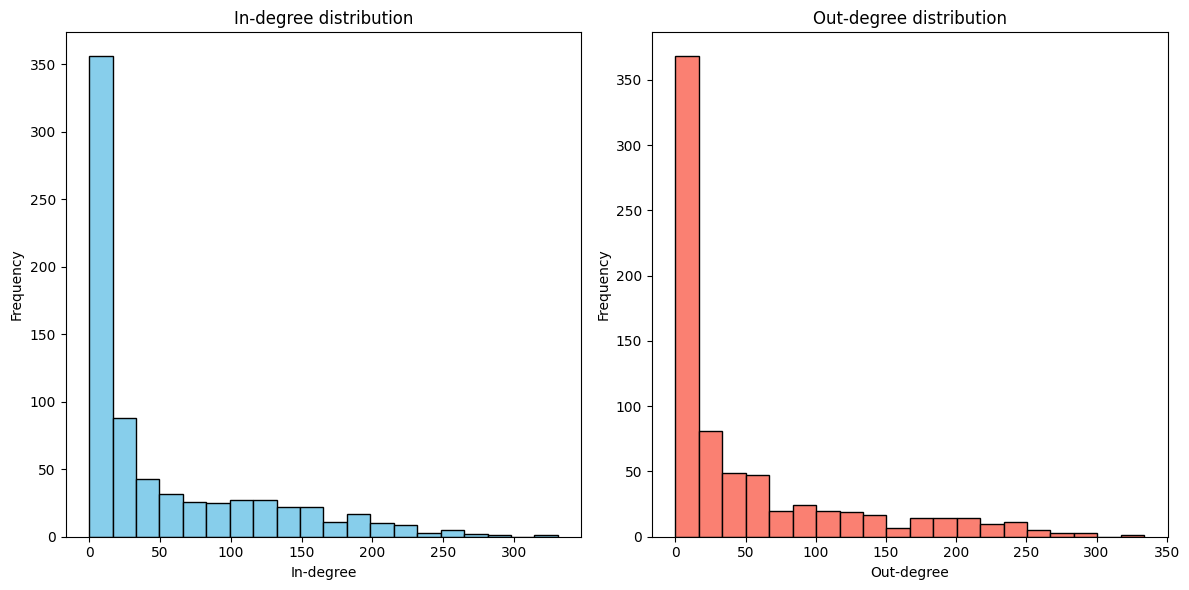

Summary report
Number of nodes: 727
Number of edges: 36719
Graph density: 0.0696
Graph type: sparse

Hubs (Airports with degree > 90th percentile):
   Airport  Total degree  In-degree  Out-degree
42     YIP           665        331         334
0      MSP           583        291         292
32     MEM           564        277         287
53     MCI           539        272         267
43     ATL           539        259         280
..     ...           ...        ...         ...
9      LGA           335        146         189
24     FWA           332        165         167
21     GRR           327        152         175
55     JAX           322        146         176
71     GSO           319        144         175

[73 rows x 4 columns]


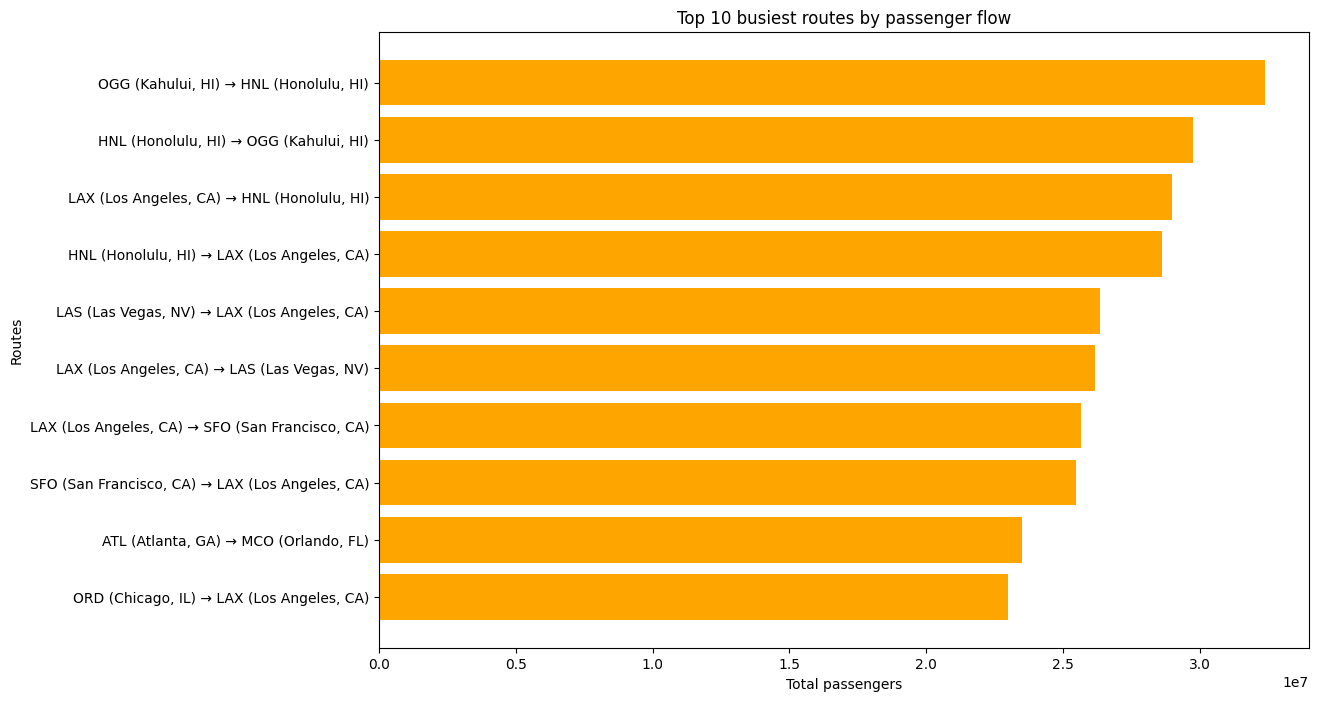

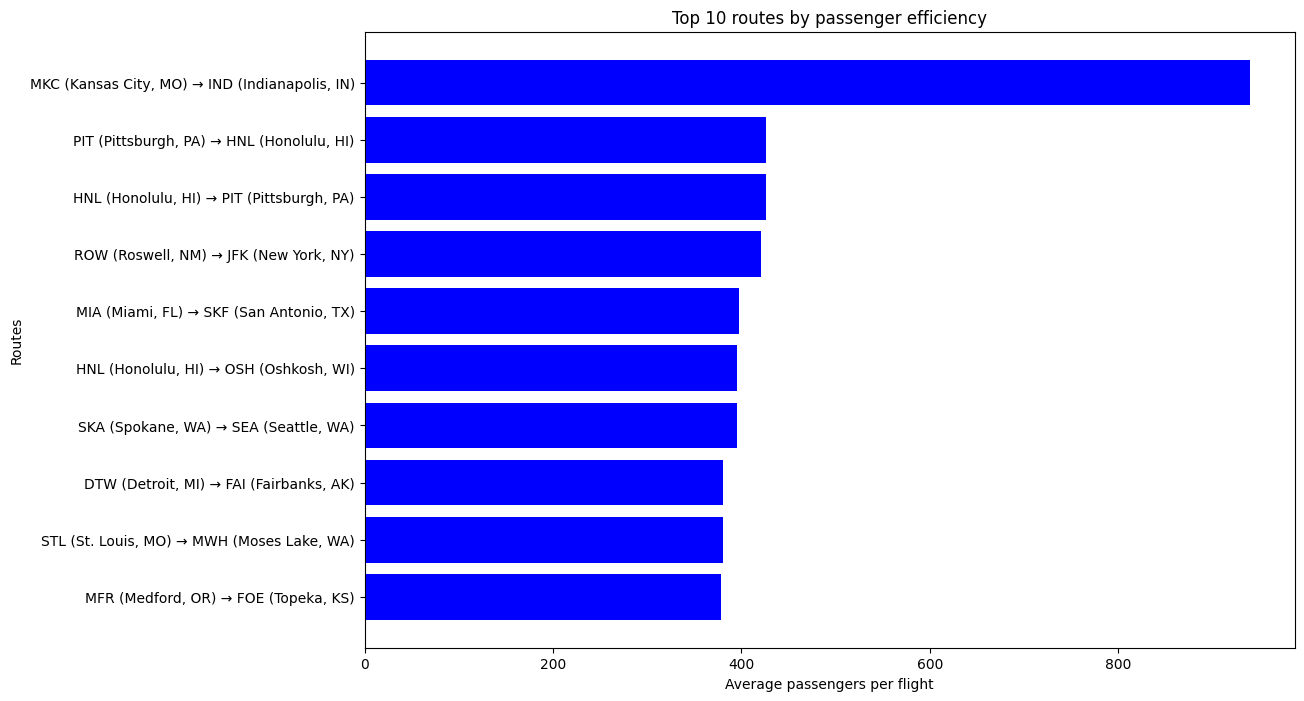


Top 10 busiest routes by passenger flow:
Origin_airport       Origin_city Destination_airport  Destination_city  Passengers
           OGG       Kahului, HI                 HNL      Honolulu, HI    32364612
           HNL      Honolulu, HI                 OGG       Kahului, HI    29744742
           LAX   Los Angeles, CA                 HNL      Honolulu, HI    28964154
           HNL      Honolulu, HI                 LAX   Los Angeles, CA    28632161
           LAS     Las Vegas, NV                 LAX   Los Angeles, CA    26333721
           LAX   Los Angeles, CA                 LAS     Las Vegas, NV    26177809
           LAX   Los Angeles, CA                 SFO San Francisco, CA    25661782
           SFO San Francisco, CA                 LAX   Los Angeles, CA    25458207
           ATL       Atlanta, GA                 MCO       Orlando, FL    23483751
           ORD       Chicago, IL                 LAX   Los Angeles, CA    22979359

Top 10 routes by passenger efficiency:
Origi

In [27]:
# Construction of the graph
flight_network = nx.DiGraph()
for i, row in airports.iterrows():
    source = row['Origin_airport']
    destination = row['Destination_airport']
    flight_network.add_edge(source, destination)

# Analyze the graph
features = analyze_graph_features(flight_network)

# Display summary and hubs table
summarize_graph_features(features)

total_flow = analyze_routes(airports)

# Visualize the busiest routes
plot_busiest_routes(total_flow)

# Visualize top routes by efficiency
plot_top_efficiency_routes(total_flow)

display_busiest_routes_table(total_flow)
display_top_efficiency_routes_table(total_flow)

#Calculate the average passengers per flight for each route and highlight under/over-utilized connections
display_routes_analysis(total_flow)

In [22]:
display_routes_analysis(total_flow)


Under-utilized Routes:
      Origin_airport Destination_airport       Origin_city  Destination_city  \
22002            SJT                 AUS    San Angelo, TX        Austin, TX   
22385            CIC                 SMF         Chico, CA    Sacramento, CA   
22484            GUP                 ABQ        Gallup, NM   Albuquerque, NM   
22915            EAT                 GEG     Wenatchee, WA       Spokane, WA   
23279            RFD                 EWR      Rockford, IL        Newark, NJ   
23341            EWN                 GSO      New Bern, NC    Greensboro, NC   
24536            ROW                 LBB       Roswell, NM       Lubbock, TX   
24548            BWI                 SBY     Baltimore, MD     Salisbury, MD   
24957            TOL                 RDU        Toledo, OH       Raleigh, NC   
24965            MHT                 MEM    Manchester, NH       Memphis, TN   
25141            GSO                 EWN    Greensboro, NC      New Bern, NC   
25256           

# Questions on the analysis : 

After completing the analysis, answer the following questions:

* **Is the graph sparse or dense?** The graph is sparse. With 727 nodes and 36,719 edges, the calculated graph density is 0.0696, which is far below 0.5. A sparse graph implies that only a small percentage of possible connections between nodes are actually realized, typical for flight networks where not all airports are directly connected.
  
* **What patterns do you observe in the degree distribution?** The degree distributions (both in-degree and out-degree) reveal that most airports have a relatively low number of connections, while a few airports have significantly higher degrees. This is a typical power-law distribution, where a small number of nodes (airports) act as hubs with many connections.
  
* **Which airports are identified as hubs, and why?** The airports are identified as hubs because their total degree (in-degree + out-degree) is higher than the 90th percentile threshold: these hubs likely serve as central nodes in the network due to their high traffic volume or their role in connecting many routes.
  
* **What are the busiest routes in terms of passenger traffic?**

  The busiest routes by passenger flow, based on the data provided, are:

1. OGG (Kahului, HI) to HNL (Honolulu, HI) – 32,364,612 passengers
2. HNL (Honolulu, HI) to OGG (Kahului, HI) – 29,744,742 passengers
3. LAX (Los Angeles, CA) to HNL (Honolulu, HI) – 28,964,154 passengers

These routes are the busiest based on the number of passengers traveling between these city pairs.
  
* **Which routes are under/over-utilized?**

**Under-utilized routes**

Routes with average passengers per flight < 0.01:

BWI → SBY (Baltimore, MD → Salisbury, MD): 0.008531
GSO → EWN (Greensboro, NC → New Bern, NC): 0.008290
CPR → RKS (Casper, WY → Rock Springs, WY): 0.007437
RFD → JFK (Rockford, IL → New York, NY): 0.007629
MHT → MEM (Manchester, NH → Memphis, TN): 0.007605
RFD → BOS (Rockford, IL → Boston, MA): 0.006689
RIW → CPR (Riverton, WY → Casper, WY): 0.005952

Routes with Extremely Low Utilization:

VIS → OAK (Visalia, CA → Oakland, CA): 0.002034
ALB → MEM (Albany, NY → Memphis, TN): 0.002830

**Over-utilized routes** 


Routes with average passenegers per flight > 300:

DTW → FAI (Detroit, MI → Fairbanks, AK): 380.8
MIA → SKF (Miami, FL → San Antonio, TX): 397.25
MCI → BGR (Kansas City, MO → Bangor, ME): 341.33
HNL → FAR (Honolulu, HI → Fargo, ND): 321.17
NZY → TPA (San Diego, CA → Tampa, FL): 316.33



# Finding Best Routes (Q3)

In [6]:
import heapq
from collections import defaultdict

def find_best_routes(airports, origin_city, destination_city, date):
    #Filter flights by date
    filtered_flights = airports[airports['Fly_date'] == date]
    
    #Construction of graphs
    city_to_airports = defaultdict(list)
    flight_graph = defaultdict(list)
    
    for i, row in filtered_flights.iterrows():
        
        origin_airport = row['Origin_airport']
        destination_airport = row['Destination_airport']
        distance = row['Distance']
        
        #Add without duplicates
        if origin_airport not in city_to_airports[row['Origin_city']]:
           city_to_airports[row['Origin_city']].append(origin_airport)
      
        if destination_airport not in city_to_airports[row['Destination_city']]:
            city_to_airports[row['Destination_city']].append(destination_airport)

        
        #Adding the edge to the graph
        flight_graph[origin_airport].append((destination_airport, distance))
    
    #Retrieve airports of specified cities
    origin_airports = city_to_airports.get(origin_city, [])
    destination_airports = city_to_airports.get(destination_city, [])
    
    if not origin_airports or not destination_airports:
        return "No route found"
    
    #Dijkstra algorithm for the shortest path
    def dijkstra(graph, start, end):
        heap = [(0, start, [])]  #(distance, current airport, path)
        visited = set()
        
        while heap:
            curr_dist, node, path = heapq.heappop(heap)
            if node in visited:
                continue
            visited.add(node)
            path = path + [node]
            
            if node == end:
                return curr_dist, path
            
            for neighbor, weight in graph[node]:
                if neighbor not in visited:
                    heapq.heappush(heap, (curr_dist + weight, neighbor, path))
        
        return float('inf'), None 
    
    #Calculation of the best paths for each pair of airports
    results = []
    for origin_airport in origin_airports:
        for destination_airport in destination_airports:
            dist, route = dijkstra(flight_graph, origin_airport, destination_airport)
            if route:
                results.append((origin_airport, destination_airport, dist, ' → '.join(route)))
            else:
                results.append((origin_airport, destination_airport, "No route found"))
    
    #Displaying results
    results_data = []

    for origin, destination, dist, route in results:
        results_data.append({
            'Origin_airport': origin,
            'Destination_airport': destination,
            'Distance': dist,
            'Best_route': route
        })

    results_df = pd.DataFrame(results_data)
    print(results_df)
        
    return results


#Exemple d'appel de la fonction
origin_city = 'Portland, OR'
destination_city = 'San Francisco, CA'
date = '2008-10-01'

In [10]:
if __name__ == "__main__":
    origin_city = input("Choose a departure city")
    destination_city = input("Choose a destination  city")
    date = input("Choose a date")
    find_best_routes(airports, origin_city, destination_city, date)
    

Choose a departure city Portland, OR
Choose a destination  city San Francisco, CA
Choose a date 2008-10-01


  Origin_airport Destination_airport  Distance Best_route
0            PDX                 SFO       550  PDX → SFO
